<br>
<img src="data/logoMoSEF.jpeg" width=90px align="left">
<div align="right">Enseignant : Florian Ielpo</div>
<div align="right">Réalisé par : ABABII Anisoara, Eunice KOFFI et DIAKITE Gaoussou</div>
<div align="right">Année : 2022/2023</div><br><br><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen">Master 2 Modélistaion Statistiques Economiques et Financières</span></div><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen">Université Paris 1 Panthéon-Sorbonne</span></div><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:28px;color:#e60000">Séries Temporelles</span></div><br><br>
<hr>



<div align="left"><span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen"> <span style="color:green">      
Introduction</span>

<p style="font-size:16px;">
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Dans ce projet, nous serons amené à travailler sur le fichier "data_exam.xlsx" qui contient différentes mesures de variance et de volatilité. Ce projet s'effectuera en plusieurs parties sous formes de questions-réponses dans lesquelles nous auront à :

- Expliquer le concept derrière chaque colonne et les transformer afin qu'elles soient comparables en elles. 
- Estimer un modèle AR sur chaque série temporelle et déterminer l'ordre du processus AR. Puis, comparer les valeurs ajustées avec les valeurs d'origine pour voir leur pertinence en termes de volatilité.
- Estimer un modèle HAR sur chaque série temporelle afin de comparer les résultats avec ceux obtenus précédemment. 
- Effectuer un test de stationnarité sur les séries temporelles estimées. 
- Estimer un modèle VAR(p) sur les trois valeurs ajustées stationnaires et analyser les résultats en traçant une fonction de réponse à une impulsion.
<p/>

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">
Analyse exploratoire des données

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from arch import arch_model
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf
from arch.univariate import HARX
import plotly.graph_objs as go
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings('ignore')
#pip install arch

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">Lecture des données

In [42]:
df = pd.read_excel("Data/data_exam.xlsx")
df = df.rename(columns={'Unnamed: 0': 'Dates'})
df.head(5)

,Dates,VIX,Parkinson,Squared returns
0,2000-01-04,27.01,0.001406,0.000612
1,2000-01-05,26.41,0.000002,0.000326
2,2000-01-06,25.73,0.000045,0.000169
3,2000-01-07,21.72,0.001577,0.000723
4,2000-01-10,21.71,0.000109,0.000111


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px"> Préparation de la base de données 

<p style="font-size:16px;">
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Tout d'abord, il sera nécessaire de convertir la date en format date-temps et de l'utiliser comme index pour pouvoir mener une analyse approfondie de nos séries. En outre, cela permettra d'identifier les tendances et les fluctuations temporelles dans nos données, ce qui facilitera la prise de décisions éclairées. De plus, la mise en index de la date nous permettra de comparer facilement différentes périodes de temps et de déterminer les facteurs qui ont eu un impact sur les résultats de notre analyse. En somme, la transformation de la date et sa mise en index constitue une étape cruciale pour obtenir des informations utiles à partir de nos séries de données.

In [43]:
#Conversion de date en date time
df['Dates'] = pd.to_datetime(df['Dates'])
df.dtypes

Dates              datetime64[ns]
VIX                       float64
Parkinson                 float64
Squared returns           float64
dtype: object

In [44]:
#On met la date en index
df = df.set_index('Dates')
df.index
df.head(5)

,VIX,Parkinson,Squared returns
Dates,,,
2000-01-04,27.01,0.001406,0.000612
2000-01-05,26.41,0.000002,0.000326
2000-01-06,25.73,0.000045,0.000169
2000-01-07,21.72,0.001577,0.000723
2000-01-10,21.71,0.000109,0.000111


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">Features Engineering

In [45]:
df['Year'] = df.index.year
print(df["Year"].value_counts().sort_index())

2000    251
2001    248
2002    252
2003    252
2004    252
2005    252
2006    251
2007    251
2008    253
2009    252
2010    252
2011    252
2012    250
2013    252
2014    252
2015    252
2016    252
2017    251
2018    251
2019    252
2020    253
2021    252
2022    256
2023     31
Name: Year, dtype: int64


<p style="font-size:16px;">
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">En observant les dates, nous pouvons constater que nos données sont disponibles sous forme de séries journalières et couvrent une période de 23 ans, allant de 2000 à 2023. Cette longue période nous permet de prendre en compte les évolutions à long terme et les tendances saisonnières dans nos analyses.  

* Nous avons constaté que le nombre d'observations n'est pas le même d'une année à l'autre. Cela peut s'expliquer par le fait que le marché n'est pas ouvert tous le temps, en particulier les week-end, les jours fériés et certains jours spécifiques. Aussi, le nombre de jours ouvrés varie d'une année sur l'autre. 
    
* La période d'observation inclut également la crise de 2008, la période COVID et la crise en Ukraine qui ont une inffluence sur les marchés boursiers.

Nous avons donc un ensemble de données riches et variées qui peuvent nous fournir des informations précieuses sur les phénomènes observés.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">Analyse des valeurs manquantes 

In [46]:
df.isna().sum()

VIX                0
Parkinson          0
Squared returns    0
Year               0
dtype: int64

<p style="font-size:16px;">
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Le résultat affiché indique qu'il n'y a aucune valeur manquante dans les colonnes VIX, Parkinson, Squared returns de notre jeu de données. Cette situation est idéale pour l'analyse et la modélisation des données car nous disposons d'un ensemble de données complet et fiable, ce qui devrait permettre des analyses plus précises et des prévisions plus fiables.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">1 . Question 1

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px"> Expliquez le concept derrière chaque colonne. Que représentent ces séries temporelles? Transformez ces séries temporelles de manière à ce qu'elles soient comparables en termes d'échelle et d'ordre.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">a- Présentation de nos trois séries 

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Colonne B: Le VIX


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px"> Egalement connu sous le nom d'indice de la peur des marchés boursiers, est un indicateur qui mesure la volatilité perçue sur le marché des actions américaines. L'indice VIX augmente généralement en cas de turbulences et de baisse des prix.

Le VIX est calculé à partir des prix des options sur l'indice S&P 500, qui permettent aux investisseurs de se protéger contre les fluctuations de l'indice boursier. Le calcul du VIX prend en compte la volatilité implicite de ces options sur une période de 30 jours. Le VIX est généralement compris entre 10 et 25 points, mais il peut atteindre des niveaux bien plus élevés en période de crise financière, comme cela s'est produit en 2008 et au printemps 2020 lors de la crise liée à la pandémie du coronavirus.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Colonne C : Le Parkinson 

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">L'indicateur Parkinson, ou Ratio Parkinson, est un indicateur technique utilisé en analyse technique pour mesurer la volatilité des prix des actions. Cet indicateur a été développé par le médecin britannique J. Michael Parkinson, d'où son nom.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">L'indicateur Parkinson est basé sur la plage de variation des prix d'une action, mesurée sur une période de temps donnée. Pour calculer l'indicateur, on prend en compte le plus haut et le plus bas prix atteints par l'action au cours de chaque période de temps. L'indicateur Parkinson mesure ensuite la différence entre ces deux prix, ce qui donne une mesure de la volatilité des prix.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Plus précisément, l'indicateur Parkinson est calculé comme suit :

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">On prend la valeur absolue de la différence entre le plus haut prix et le plus bas prix de chaque période de temps. Ensuite, on multiplie cette valeur absolue par la racine carrée du nombre de périodes de temps. On divise au final le résultat obtenu par le cours de clôture de l'action.
L'indicateur Parkinson est aussi utilisé pour mesurer la volatilité d'un marché ou d'une action spécifique; et pour déterminer les niveaux de stop-loss et de prise de bénéfices pour les investisseurs.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Colonne D : L'indicateur Squared Returns

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">L'indicateur Squared Returns est la mesure de la volatilité historique d'un actif financier. Plus précisément, il mesure la variance des rendements (c'est-à-dire des variations de prix) d'un actif sur une période de temps donnée.

Cet indicateur est calculé en prenant les rendements de l'actif pour chaque période de temps (par exemple, chaque jour de négociation) et en les carrant. Ensuite, la moyenne de ces carrés de rendements est calculée, ce qui donne la variance des rendements. L'indicateur Squared Returns est exprimé en pourcentage.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Comme l'indicateur Parkinson, l'indicateur Squared Returns est utilisé pour mesurer la volatilité d'un actif sur différentes périodes de temps, de la plus courte à la plus longue. Cependant, il est  utilisé pour mesurer la volatilité à moyen et long terme, sur des périodes allant de quelques mois à plusieurs années.

In [47]:
def graph(df):
    for col in df.columns[0:3]:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col))
        fig.update_layout(
            title=f"Evolution de l'indice {col} dans le temps",
            xaxis_title='Date',
            yaxis_title=col
        )
        fig.show()

graph(df)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Interprétation des graphiques

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Les graphiques représentent trois séries temporelles: la volatilité du marché (VIX), la mesure de la volatilité Parkinson et les retours carrés, sur une période de 23 ans, de 2000 à 2023. Nous avons observé des pics pour les trois séries en 2008 et 2020, ce qui pourrait être attribué à des événements économiques significatifs tels que la crise financière de 2008 et la pandémie de COVID-19 en 2020. La série VIX a une échelle plus élevée que les deux autres séries, ce qui peut être attribué à sa nature spécifique de mesure de la volatilité du marché. Donc, dans ce cas les investisseurs peuvent devenir plus prudents et adopter une stratégie d'investissement à haut risque

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">En plus de l'analyse visuelle des graphiques, il serait intéressant d'explorer davantage les caractéristiques des séries en calculant les moments de chaque série pour comprendre comment elles varient au cours du temps. Les moments pourraient inclure la moyenne, l'écart-type, la variance, l'asymétrie et l'aplatissement. Cette analyse plus approfondie pourrait fournir des informations supplémentaires sur les propriétés de chaque série, telles que leur niveau de volatilité, leur tendance et leur distribution. Ces résultats pourraient également aider à identifier des modèles cachés ou des comportements atypiques qui ne seraient pas apparents à partir de l'analyse visuelle seule

<br>
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px;">Calcule des moments de chaque série</span>

In [48]:
def compute_stats(df):
    # Calculer la moyenne de chaque colonne
    means = df.mean()

    # Calculer la variance de chaque colonne
    variances = df.var()

    # Calculer l'écart-type de chaque colonne
    stds = df.std()

    # Afficher les résultats pour chaque colonne
    for col in df.columns:
        print(15*' - ', col, 15*' - ')
        print("Moyenne de la série {} : {}".format(col, means[col]))
        print("Variance de la série {} : {}".format(col, variances[col]))
        print("Ecart type de la série {} : {}".format(col, stds[col]))
        print('     ')

compute_stats(df.iloc[:,0:3])
df = df.iloc[:,0:3]

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  VIX  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Moyenne de la série VIX : 20.191310546204054
Variance de la série VIX : 75.2548055833243
Ecart type de la série VIX : 8.674952771244596
     
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  Parkinson  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Moyenne de la série Parkinson : 0.00015602758154367863
Variance de la série Parkinson : 3.30641177769203e-07
Ecart type de la série Parkinson : 0.0005750140674533128
     
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  Squared returns  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Moyenne de la série Squared returns : 0.00014549660069859918
Variance de la série Squared returns : 1.168814504745858e-07
Ecart type de la série Squared returns : 0.00034187929225764144
     


<br>
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px"> Commentaire des moments de chaque série</span>

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Les moments statistiques tels que la moyenne, la variance et l'écart type sont des mesures clés pour comprendre les caractéristiques d'une série temporelle. En analysant les moments de ces trois séries, nous pouvons voir que la série VIX a une moyenne de 20.19 et une variance de 75.25, ce qui indique une variation plus importante dans les données. En revanche, les séries Parkinson et Squared returns ont des moyennes plus proches de zéro, des variances plus faibles et des écarts types plus petits, ce qui suggère que ces séries sont plus stables et moins volatiles. Ces informations sont précieuses pour comprendre les caractéristiques de chaque série et aider à identifier les modèles et les tendances dans les données.

<br>
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Réflexion sur la méthode utilisée pour homogénéiser les échelles des séries temporelles.</span>

<p style="font-size:16px;">
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Dans l'objectif de comparer les séries VIX, Parkinson et Squared returns, il est important de les mettre à la même échelle. Pour ce faire, nous avons décidé dans un premier temps d'annualiser les séries. En effet, l'annualisation permet de rendre la comparaison entre différentes échelles de temps plus facile et plus précise. Nous avons ainsi multiplié les séries journalières par le nombre de jours de trading 252 annuels. 

Après cette etape les séries VIX, Parkinson et Squared returns, nous avons opté pour la méthode de normalisation Min-Max qui consiste à ramener toutes les valeurs d'une série dans un intervalle [0,1] en se basant sur leur minimum et leur Maximum. Cette méthode est choisie car elle préserve les écarts entre les valeurs tout en permettant de les mettre à la même échelle. De plus, elle est simple à mettre en œuvre et ne nécessite pas de connaître la distribution des données. 
<p/>


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Annualisation des séries </span>

In [49]:
df['VIX'] = np.sqrt(252) * df['VIX']
df['Parkinson'] = np.sqrt(252) * df['Parkinson']
df['Squared returns'] = np.sqrt(252) * df['Squared returns']

<p style="font-size:16px;"> 
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Par exemple, pour annualiser l'indice VIX journalier, nous utilisons la formule suivante :

VIX annuel = VIX journalier * racine carrée de (252): où 252 représente le nombre de jours de négociation dans une année typique. En multipliant le VIX journalier par la racine carrée de 252, nous estimons une volatilité implicite attendue pour une année complète. 
<p/>

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Application de la méthode Min-Max</span>

<p style="font-size:16px;">
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
La standardisation Min-Max est considérée comme optimale pour les séries VIX et Parkinson, Squared Returns car :

- elles sont des séries temporelles qui ont des valeurs très différentes au fil du temps; et que la standardisation Min-Max permet de mettre en évidence les variations relatives de ces valeurs, ce qui est important pour l'analyse de la volatilité.

- cette technique simple est aussi facile à mettre en œuvre et qui ne nécessite pas beaucoup de ressources computationnelles.

La standardisation Min-Max dans notre cas est facilement interprétée car elle met les valeurs des 3 séries de données dans une plage prédéfinie (entre 0 et 1). Cela facilite la comparaison des valeurs des séries de données, et permet dans le même temps de transformer les séries temporelles de manière à ce qu'elles soient comparables en termes d'échelle et d'ordre.<p/>

In [50]:
def normalize_dataframe(df, columns_to_normalize):
    scaler = MinMaxScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

normalize_dataframe(df, ['VIX', 'Parkinson', 'Squared returns'])
df.shape

(5822, 3)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">
Nouvelle visualisation des données après leur mise à l'échelle commune</span>


In [51]:
graph(df)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Recalcule des momments de nos séries</span>

In [52]:
compute_stats(df)

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  VIX  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Moyenne de la série VIX : 0.15025575181786613
Variance de la série VIX : 0.013911337401098272
Ecart type de la série VIX : 0.11794633271576642
     
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  Parkinson  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Moyenne de la série Parkinson : 0.00783322853896753
Variance de la série Parkinson : 0.0008333660048737322
Ecart type de la série Parkinson : 0.028868079341614193
     
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  Squared returns  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Moyenne de la série Squared returns : 0.02338899233309484
Variance de la série Squared returns : 0.0030810180359129406
Ecart type de la série Squared returns : 0.055506918811198125
     


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Après avoir appliqué la méthode Min-Max pour mettre les séries sur la même échelle, ainsi qu'annualisér les deux séries, nous pouvons constater les nouveaux moments des séries. Nous remarquons que la moyenne, la variance et l'écart-type de la série VIX reste la plus élevée parmi les autres séries. En outre, la série Parkinson montre toujours la variance et l'écart-type les plus bas parmi toutes les séries. Ces informations sont utiles pour l'analyse et la comparaison des séries.</p>

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">2. Question 2

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Estimez un modèle AR pour chaque série temporelle. Déterminez l'ordre du processus AR et montrez les estimations. Que pouvez-vous conclure à partir de ces estimations?</span>

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">a.1- Test de stationnarité de nos trois séries

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Avant d'estimer un modèle AR ou de déterminer son ordre, il est important de s'assurer que la série à modéliser est stationnaire. Une série est considérée comme stationnaire lorsque ses propriétés statistiques, telles que la moyenne, la variance et la covariance, ne varient pas avec le temps. Les modèles AR sont construits sur l'hypothèse que la série est stationnaire, et ne sont donc pas appropriés pour des séries non stationnaires.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Si une série n'est pas stationnaire, il est nécessaire de la transformer pour la rendre stationnaire avant d'estimer le modèle AR. Pour ce faire, on peut utiliser l'autocorrélogramme et les test de Dickey-Fuller, PP et KPSS pour détecter la présence de tendances et de saisonnalité dans la série. Si des tendances sont présentes, on peut les éliminer en différenciant la série. Ensuite, on peut estimer le modèle AR à partir de la série différenciée pour obtenir des prévisions fiables.

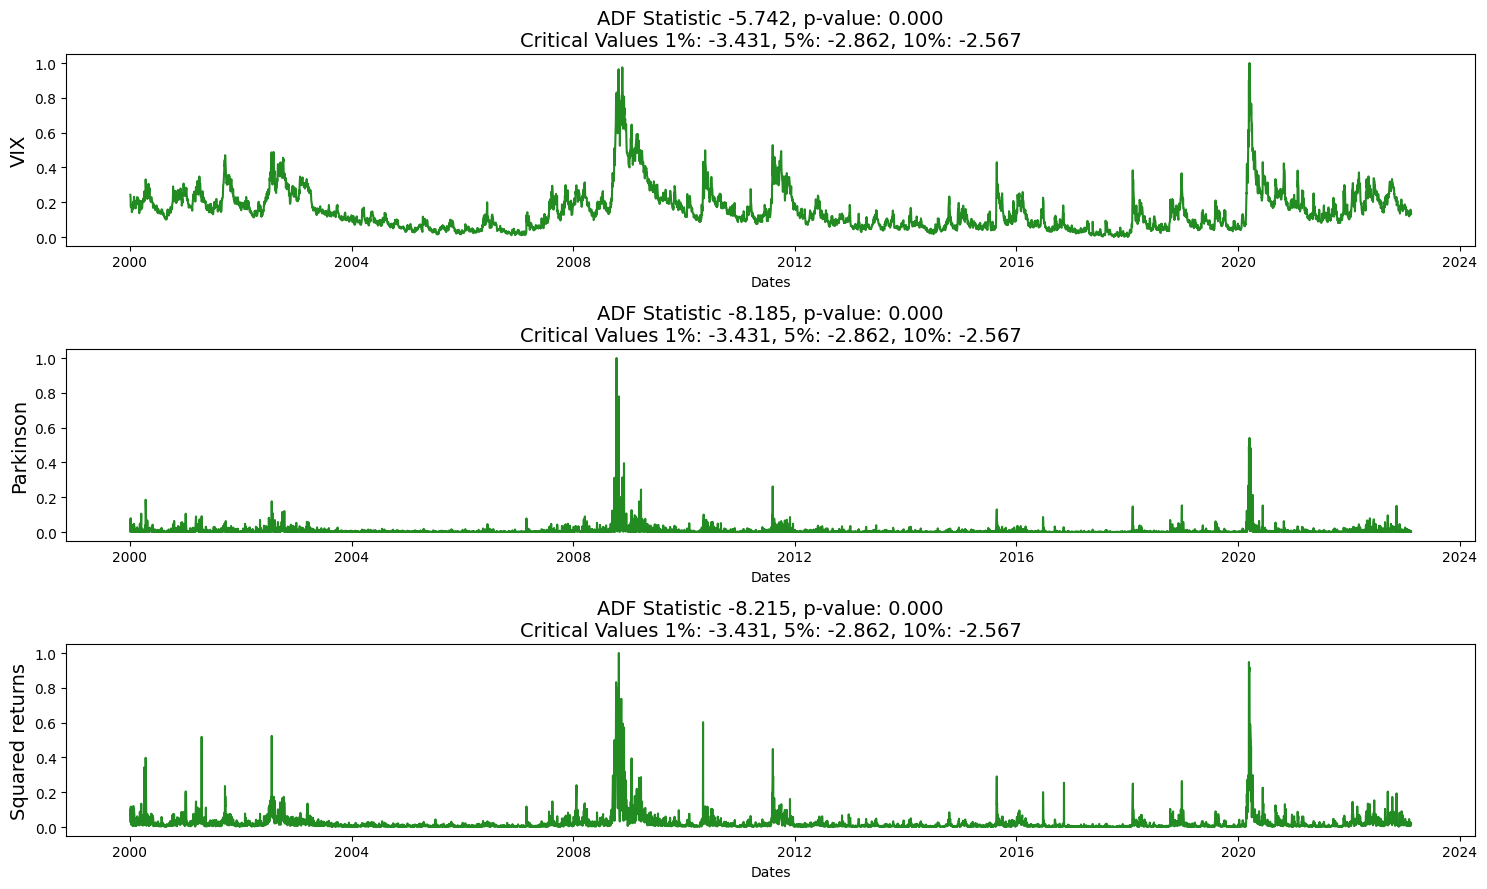

In [53]:
def visualize_adfuller_results(series, title,df, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df.index, y=series, ax=ax, color=linecolor) 
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    

def visualize_series(df):
    f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 9))

    series_names = ['VIX', 'Parkinson', 'Squared returns']

    for i in range(len(series_names)):
        series_name = series_names[i]

        visualize_adfuller_results(df[series_name].values, series_name, df, ax[i])

    plt.tight_layout()
    plt.show()
    
visualize_series(df)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Après avoir effectué le test de Dickey-Fuller augmenté (ADF) sur nos trois séries temporelles, nous avons observé des valeurs de p inférieures à 0.05 pour toutes les séries, ce qui nous a permis de rejeter l'hypothèse nulle de non-stationnarité de nos séries pour ce test. Cependant, en analysant les graphiques des séries temporelles, nous avons remarqué des tendances plus fortes qui ne sont pas captées par le test de Dickey-Fuller augmenté. Pour cette raison, nous avons décidé d'appliquer d'autres tests, tels que les tests de Phillips-Perron et KPPS, pour mieux comprendre la stationnarité de nos séries temporelles.

In [56]:
def stationnarite(data, vars_list):
    sig = 0.01
    res_df = pd.DataFrame(columns=['VARS', 'ADF TEST/FOR/UNIT ROOT', 'P-VALUE/FOR/ADF TEST',
                                   'PP TEST/FOR/UNIT ROOT', 'P-VALUE/FOR/PP TEST',
                                   'KPSS TEST/FOR/STATIONNARITE', 'P-VALUE/FOR/KPSS TEST', 'STATIONNARITE/FLAG'])
    loop = 1
    for x in vars_list:
        adf_result = adfuller(data[x], autolag='AIC')
        pp_result = PhillipsPerron(data[x])
        kpss_result = kpss(data[x])
        if (adf_result[1] < sig and pp_result.pvalue > sig and kpss_result[1] > sig) :
            flg = "Stationnarity" 
        elif (adf_result[1] > sig and pp_result.pvalue > sig and kpss_result[1] > sig):
            flg = "Stationnarity" 
        elif (adf_result[1] > sig and pp_result.pvalue > sig and kpss_result[1] < sig):
            flg = "Non-Stationarity" 
        elif (adf_result[1] > sig and pp_result.pvalue < sig and kpss_result[1] > sig):
            flg = "Non-Stationarity" 
        elif (adf_result[1] > sig and pp_result.pvalue < sig and kpss_result[1] < sig):
            flg = "Non-Stationarity" 
        elif (adf_result[1] < sig and pp_result.pvalue > sig and kpss_result[1] < sig):
            flg = "Stationarity" 
        elif (adf_result[1] < sig and pp_result.pvalue < sig and kpss_result[1] > sig):
            flg = "Stationarity"
        elif (adf_result[1] < sig and pp_result.pvalue < sig and kpss_result[1] < sig):
            flg = "Non-Stationarity"
        else:
            flg = "Non Stationnarity" 
            
        res_df = res_df.append({'VARS': x.upper(),
                                'ADF TEST/FOR/UNIT ROOT': adf_result[0],
                                'P-VALUE/FOR/ADF TEST': adf_result[1],
                                'PP TEST/FOR/UNIT ROOT': pp_result.stat,
                                'P-VALUE/FOR/PP TEST': pp_result.pvalue,
                                'KPSS TEST/FOR/STATIONNARITE': kpss_result[0],
                                'P-VALUE/FOR/KPSS TEST': kpss_result[1],
                                'STATIONNARITE/FLAG': flg,
                                '_i': loop}, ignore_index=True)
        loop += 1
    res_df = res_df.sort_values(by=['_i'])
    del res_df['_i']
    return res_df

stationnarite(df, df.iloc[:,0:3])

,VARS,ADF TEST/FOR/UNIT ROOT,P-VALUE/FOR/ADF TEST,PP TEST/FOR/UNIT ROOT,P-VALUE/FOR/PP TEST,KPSS TEST/FOR/STATIONNARITE,P-VALUE/FOR/KPSS TEST,STATIONNARITE/FLAG
0,VIX,-5.742412,6.231456e-07,-7.102796,4.126338e-10,0.621337,0.020697,Stationarity
1,PARKINSON,-8.185235,7.932428e-13,-93.389293,0.000000e+00,0.169003,0.100000,Stationarity
2,SQUARED RETURNS,-8.214812,6.668163e-13,-51.889927,0.000000e+00,0.195996,0.100000,Stationarity


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Les deux dérnieres séries sont stationnaire au seuil de 5 %, hypothese vérifiée par les tests de stationarité, alors que la serie de VIX est stationnaire pour les tests de PP et KPSS au seuil de 1%.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Commentaire

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Après avoir appliqué les tests de stationnarité, nous avons obtenu des séries qui verifient les hypotheses de stationnarité suivantes :

- E[X(t)] = µ < infinit (l'esperence de la série ne depend pas de temps)
- V[X(t)] = sigma < infinit (la variance de la série ne depend pas de temps)
- Cov[X(t), X(t-h)] = f(h) < infinit (la covariance entres 2 séries X(t) et X(t-h) est independante du temps et est définie).  

Ces étapes nous permetent alors de passer à l'indentification de l'ordre AR de nos 3 indicateurs.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">a.2. Analyse de l'ACF pour la preuve de stationnarité

In [57]:
def plot_autocorrelation(dataframe, columns, lags=100, figsize=(20, 12)):
    f, ax = plt.subplots(nrows=len(columns), ncols=1, figsize=figsize)

    for i, col in enumerate(columns):
        plot_acf(dataframe[col], lags=lags, ax=ax[i])
        ax[i].set_title(f'Autocorrelation de la série {col}')
    
    plt.show()

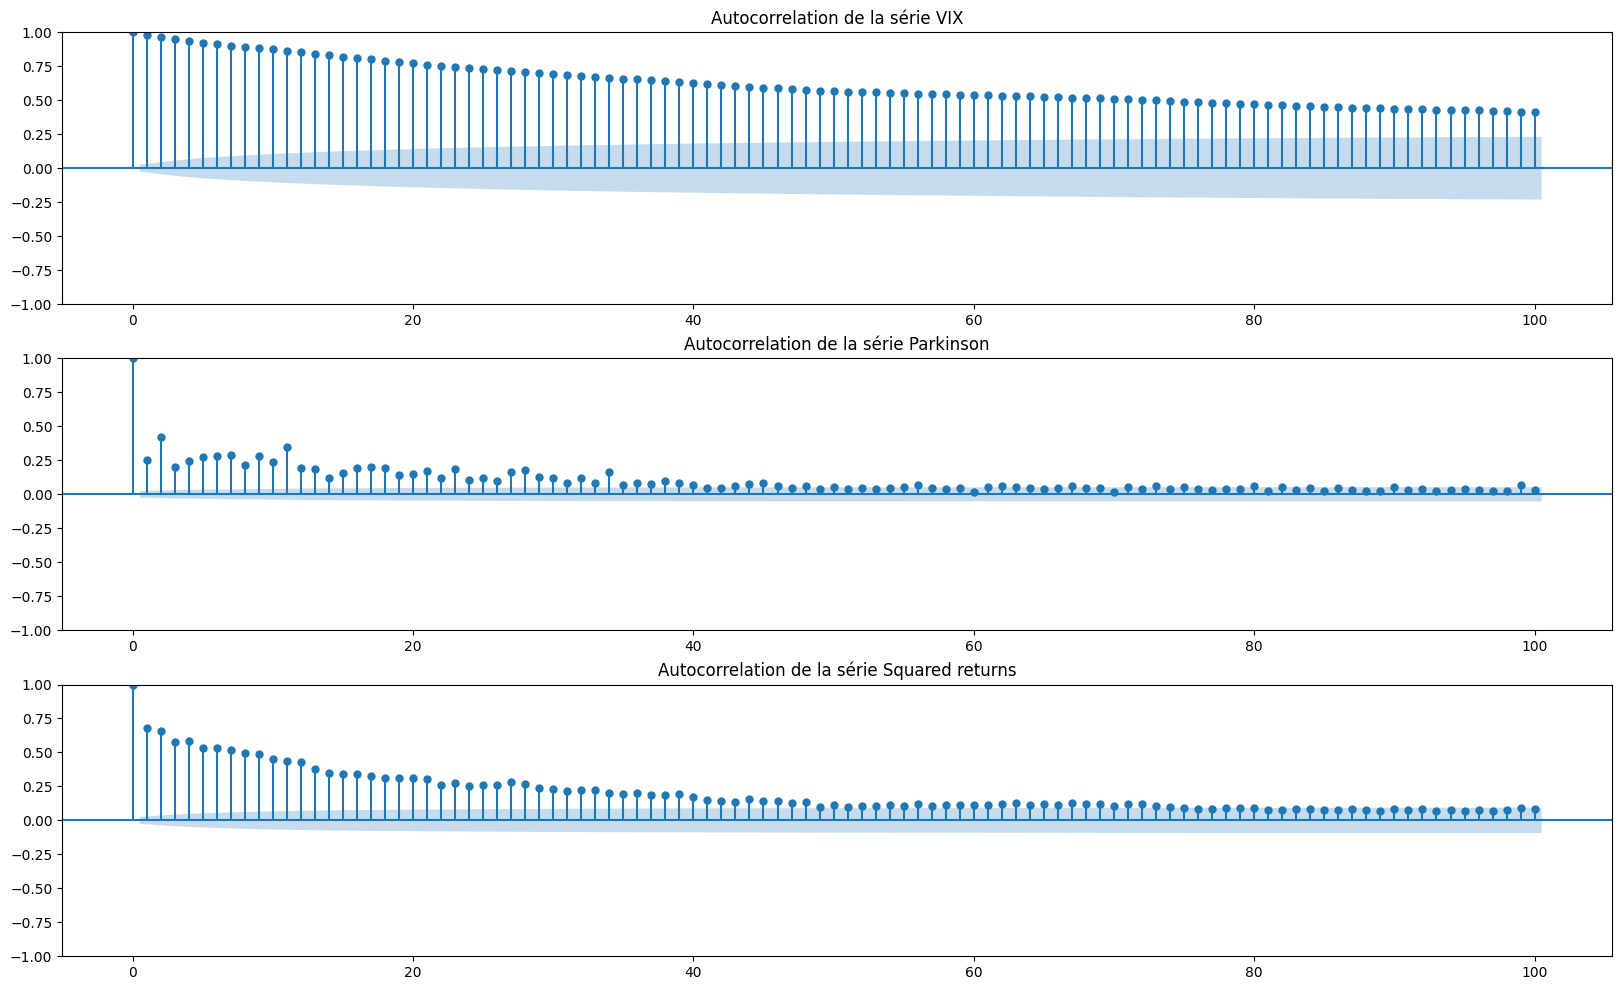

In [58]:
plot_autocorrelation(df, ['VIX', 'Parkinson', 'Squared returns'])

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Commentaire

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">La conclusion de stationnarité est également étayée par l'examen des graphiques de l'ACF, qui montrent une décroissance rapide des corrélations entre les observations à différents moments dans le temps. 

Cette stationnarité est une condition préalable importante pour utiliser des modèles AR afin de modéliser et prévoir les données. En utilisant ces outils de diagnostic ensemble, nous pouvons avoir une meilleure compréhension de la structure de la série temporelle et choisir le modèle AR optimal pour obtenir des prévisions fiables.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">b- Détermination de l'ordre AR

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Maintenant, nous allons déterminer l'ordre AR pour chacune des trois séries. Pour cela, nous allons utiliser les critères d'information AIC (Akaike Information Criterion) et BIC (Bayesian Information Criterion) pour estimer le meilleur ordre AR parmi plusieurs ordres. Nous avons utilisé une fonction appelée ar_order qui prend en entrée une série temporelle et un nombre maximal d'ordre AR à considérer. Cette fonction calcule l'AIC et le BIC pour chaque ordre AR et renvoie l'ordre AR optimal qui minimise l'un des deux critères, en fonction de celui qui est le plus petit.

In [133]:
def ar_order(data, max_order):
    """
    Identifie l'ordre d'un processus AR pour une série temporelle 1D en utilisant les critères BIC et AIC.
    """

    # Initialisation
    aic = np.zeros(max_order + 1)
    bic = np.zeros(max_order + 1)

    # Calcul des critères BIC et AIC pour chaque ordre
    for i in range(1, max_order + 1):
        model = AutoReg(data, i)
        results = model.fit()
        aic[i] = results.aic
        bic[i] = results.bic

    # Identification de l'ordre à partir des critères BIC et AIC
    aic_order = np.argmin(aic)
    bic_order = np.argmin(bic)

    if aic_order == bic_order:
        order = aic_order
    else:
        order = min(aic_order, bic_order)

    return order

In [60]:
column_name = 'VIX'
column_data = df[column_name].to_numpy()
# Calculer l'ordre du processus AR
max_order = 15
order = ar_order(column_data, max_order)
print(f"L'ordre du processus AR identifié pour la séries VIX est {order}.")

L'ordre du processus AR identifié pour la séries VIX est 5.


In [61]:
column_name = 'Parkinson'
column_data = df[column_name].to_numpy()
# Calculer l'ordre du processus AR
max_order = 20
order = ar_order(column_data, max_order)
print(f"L'ordre du processus AR identifié pour la séries Parkinson est {order}.")

L'ordre du processus AR identifié pour la séries Parkinson est 14.


In [62]:
column_name = 'Squared returns'
column_data = df[column_name].to_numpy()
# Calculer l'ordre du processus AR
max_order = 20
order = ar_order(column_data, max_order)
print(f"L'ordre du processus AR identifié pour la séries Squared returns est {order}.")

L'ordre du processus AR identifié pour la séries Squared returns est 7.


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">Graphiques d'autocorrélation partielle (PACF)**

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour valider l'ordre AR obtenu à l'aide des critères d'information AIC et BIC, il est recommandé de vérifier visuellement si les autocorrélations partielles des résidus sont significatives en utilisant des graphiques tels que (PACF).

In [63]:
def plot_pacf_series(df):
    f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 16))

    plot_pacf(df['VIX'], lags=20, ax=ax[0])
    ax[0].set_title('Autocorrelation Partielle de la série VIX')

    plot_pacf(df['Parkinson'], lags=20, ax=ax[1])
    ax[1].set_title('Autocorrelation Partielle de la série Parkinson')

    plot_pacf(df['Squared returns'], lags=20, ax=ax[2])
    ax[2].set_title('Autocorrelation Partielle de la série Squared returns')

    plt.show()

def plot_significant_ar_coeffs(df, column_name, lags=20, alpha=0.05):
    """
    Cette fonction calcule d'abord les coefficients PACF et 
    les intervalles de confiance en utilisant la fonction pacf, 
    puis identifie les coefficients significatifs, et enfin trace le PACF 
    avec les coefficients significatifs mis en évidence en bleu.
    """
    # Calculate PACF and confidence intervals
    pacf_coeffs, confint = pacf(df[column_name], nlags=lags, alpha=alpha)

    # Identify significant coefficients
    sig_coeffs = [coeff if confint[i][0] < 0 and confint[i][1] > 0 else None for i, coeff in enumerate(pacf_coeffs)]

    # Plot PACF with significant coefficients in red
    fig, ax = plt.subplots()
    plot_pacf(df[column_name], lags=lags, ax=ax)
    ax.plot(sig_coeffs, 'o', markersize=5, color='red')
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=2)
    plt.show()

    # Identify the order of the AR process
    max_order = min(40, len(df[column_name]) - 1)
    order = ar_order(df[column_name], max_order)
    print(f"Ordre AR identifié : {order}")

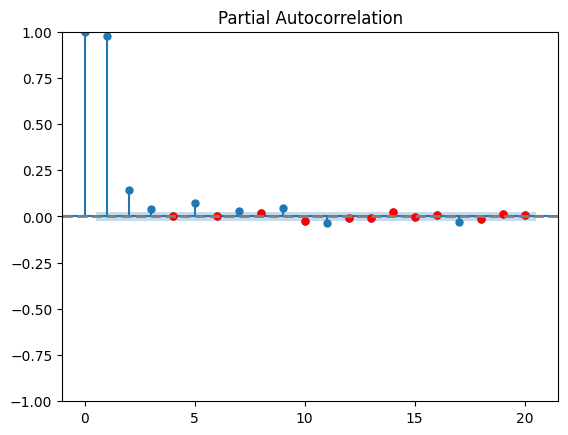

Ordre AR identifié : 5


In [64]:
plot_significant_ar_coeffs(df, "VIX", lags=20, alpha=0.05)

 <div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Les coefficients significatifs sont affichés sur le graphique en bleu. On peut voir que le 5-eme coefficient est significatifs, ce qui suggère que l'ordre du processus AR est 5.
 VIX suit un processus AR(5)

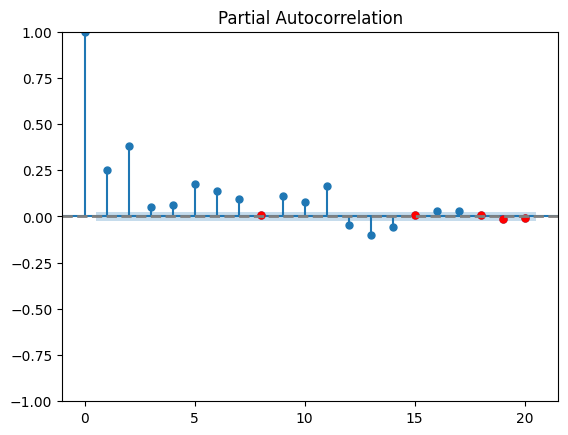

Ordre AR identifié : 14


In [65]:
plot_significant_ar_coeffs(df, "Parkinson", lags=20, alpha=0.05)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">La serie Parkinson suit un processus AR(14)

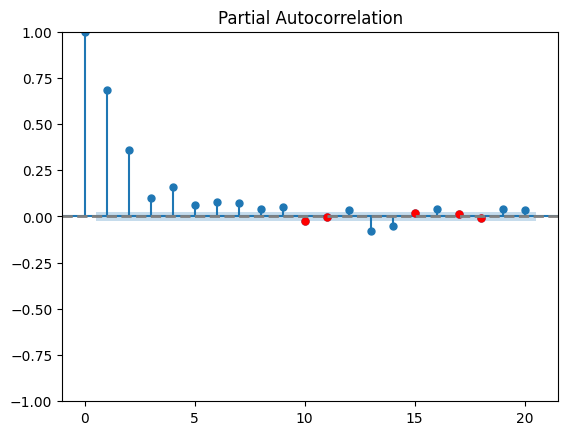

Ordre AR identifié : 7


In [66]:
plot_significant_ar_coeffs(df, "Squared returns", lags=20, alpha=0.05)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Squared returns suit un AR(7)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Ce qu'on peut déduire c'est que la fonction PACF permet de visualiser la corrélation partielle entre une observation et ses observations retardées, ce qui peut donner une indication de l'ordre du processus AR. Les critères AIC/BIC, utilisent une approche plus statistique pour évaluer la qualité de l'ajustement du modèle AR en fonction de l'ordre. Donc, dans notre cas, nous remarquons  que les critères AIC/BIC retournent le même ordre AR que la fonction PACF.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Les résultats obtenus pour l'ordre AR optimal pour chacune des séries temporelles suggèrent que le processus sous-jacent est un processus auto-régressif d'ordre 5 pour la série VIX, et d'ordre 14 et 7 pour les séries Parkinson et Squared Returns.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Cela signifie qu'il est recommandé de construire des modèles AR avec ces ordres respectifs pour chaque série. 

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">c- Estimation du modèle AR 

In [87]:
def fit_ar_models(df, column):
    results_VIX = None
    results_Parkinson = None
    results_Squared_returns = None

    # Estimate AR model on VIX
    if column == 'VIX':
        model_vix = AutoReg(df[column], lags=4, trend='c', old_names=False)
        results_vix = model_vix.fit()
        print('AR Model for VIX:')
        print(results_vix.summary())
        
    # Estimate AR model on Parkinson
    elif column == 'Parkinson':
        model_parkinson = AutoReg(df[column], lags=14, trend='c', old_names=False)
        results_parkinson = model_parkinson.fit()
        print('AR Model for Parkinson:')
        print(results_parkinson.summary())
    
    # Estimate AR model on Squared Returns
    elif column == 'Squared returns': 
        model_squared = AutoReg(df[column], lags=7, trend='c', old_names=False)
        results_squared = model_squared.fit()
        print('AR Model for Squared Returns:')
        print(results_squared.summary())
    
    return None


In [88]:
results_vix = fit_ar_models(df, 'VIX')

AR Model for VIX:
                            AutoReg Model Results                             
Dep. Variable:                    VIX   No. Observations:                 5822
Model:                     AutoReg(4)   Log Likelihood               13380.160
Method:               Conditional MLE   S.D. of innovations              0.024
Date:                Tue, 04 Apr 2023   AIC                         -26748.319
Time:                        21:27:30   BIC                         -26708.307
Sample:                             4   HQIC                        -26734.403
                                 5822                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      5.192      0.000       0.002       0.004
VIX.L1         0.8357      0.013     63.769      0.000       0.810       0.861
VIX.L2         0.1055      0.017  

In [86]:
results_parkinson = fit_ar_models(df, 'Parkinson')

AR Model for Parkinson:
                            AutoReg Model Results                             
Dep. Variable:              Parkinson   No. Observations:                 5822
Model:                    AutoReg(14)   Log Likelihood               13362.939
Method:               Conditional MLE   S.D. of innovations              0.024
Date:                Tue, 04 Apr 2023   AIC                         -26693.879
Time:                        21:27:11   BIC                         -26587.207
Sample:                            14   HQIC                        -26656.774
                                 5822                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0017      0.000      4.856      0.000       0.001       0.002
Parkinson.L1      0.0608      0.013      4.639      0.000       0.035       0.086
Parkinson.L2    

In [89]:
results_squared = fit_ar_models(df, 'Squared returns')

AR Model for Squared Returns:
                            AutoReg Model Results                             
Dep. Variable:        Squared returns   No. Observations:                 5822
Model:                     AutoReg(7)   Log Likelihood               10934.539
Method:               Conditional MLE   S.D. of innovations              0.037
Date:                Tue, 04 Apr 2023   AIC                         -21851.077
Time:                        21:27:40   BIC                         -21791.064
Sample:                             7   HQIC                        -21830.203
                                 5822                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0029      0.001      5.325      0.000       0.002       0.004
Squared returns.L1     0.3677      0.013     28.114      0.000       0.342   

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">

Ces estimations correspondent à un modèle autorégressif (AR) d'ordre 5 appliqué au VIX, qui est un indice de volatilité du marché financier. Les coefficients indiquent l'impact de chaque observation passée sur la valeur actuelle du VIX. Les résultats montrent que les cinq dernières valeurs du VIX ont un impact significatif sur la valeur actuelle du VIX, avec des coefficients positifs pour les deux dernières valeurs et négatifs pour les troisième et quatrième dernières valeurs. Le coefficient du troisième décalage est légèrement positif mais non significatif. Les racines caractéristiques du modèle AR sont toutes situées à l'intérieur du cercle unité, ce qui indique que le modèle est stationnaire et stable. En général, ce modèle peut être utilisé pour prévoir la valeur future du VIX en fonction de ses valeurs passées.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Les résultats montrent que le modèle AR (AutoReg) d'ordre 14 est capable de bien ajuster les données observées pour la série de Parkinson. La constante (const) et les coefficients des 14 retards (Parkinson.L1 à Parkinson.L14) sont tous significatifs avec des valeurs de p inférieures à 0,05, sauf pour Parkinson.L3 et Parkinson.L8 qui ne sont pas significatifs. Les racines (Roots) indiquent qu'il y a 14 racines complexes et que leur fréquence est répartie de manière égale entre les parties réelles positives et négatives, ce qui suggère que le modèle est stable. Dans l'ensemble, le modèle AR semble être un choix approprié pour modéliser la série chronologique de Parkinson.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Le modèle AR pour les carrés des rendements a un AIC de -21851.077, ce qui indique une bonne qualité d'ajustement. En outre, la plupart des coefficients de retard sont significatifs, avec une valeur p inférieure à 0,05, à l'exception de Squared returns.L3, et Squared returns.L5. Cela indique que les retards sont importants pour prédire les carrés des rendements et que les rendements sont fortement corrélés à leurs retards. Cela peut suggérer que le modèle peut être utilisé pour prédire les niveaux de volatilité futurs et pour identifier les points de basculement dans la volatilité.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">3. Question 3
</span></div> 

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">
Tracez les valeurs ajustées pour chaque modèle par rapport à la série chronologique d'origine. Pourquoi ces valeurs ajustées sont-elles intéressantes pour mesurer la volatilité ?</span></div> 

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Dans cette partie, nous allons tracer les valeurs ajustées pour chaque modèle par rapport à la série chronologique d'origine. Cette visualisation nous permettra d'évaluer la performance de chaque modèle dans la prédiction de la volatilité. Les valeurs ajustées représentent la volatilité prédite par chaque modèle, ce qui nous permettra de comparer la volatilité réelle avec la volatilité prédite. Cela nous aidera à comprendre si les modèles sont capables de capturer la variabilité de la série temporelle et si les valeurs ajustées peuvent être utilisées pour mesurer la volatilité de manière fiable.

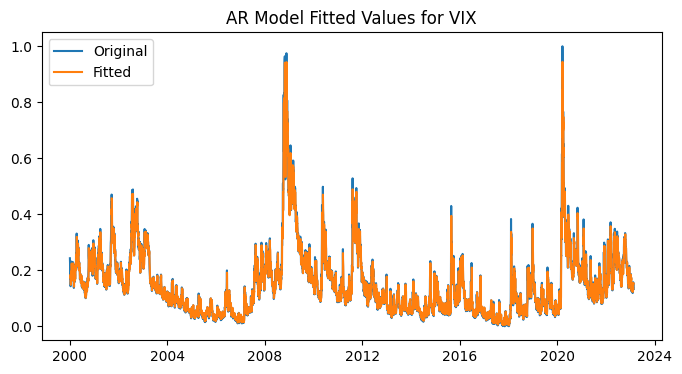

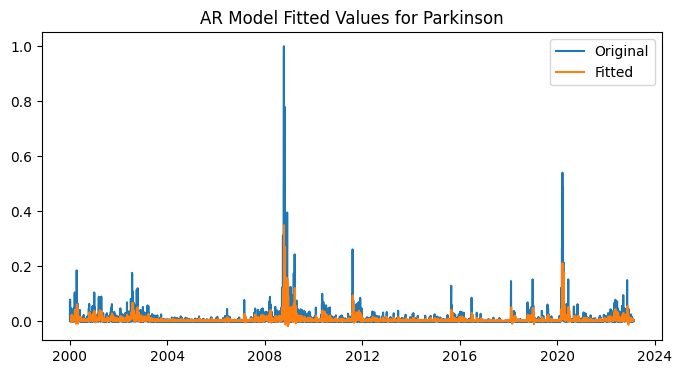

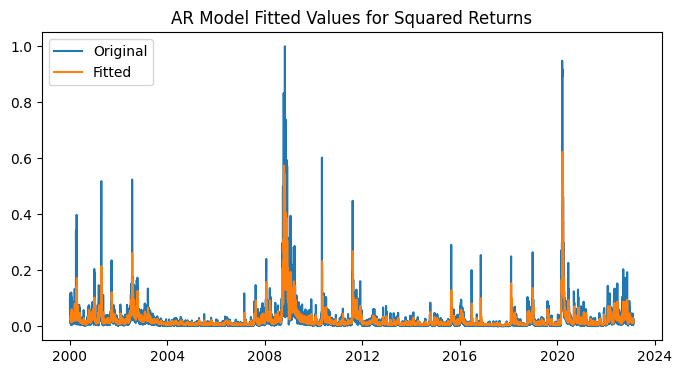

In [76]:
def plot_ar_fitted_values(df, results_vix, results_parkinson, results_squared):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(df['VIX'], label='Original')
    ax.plot(results_vix.fittedvalues, label='Fitted')
    ax.set_title('AR Model Fitted Values for VIX')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(df['Parkinson'], label='Original')
    ax.plot(results_parkinson.fittedvalues, label='Fitted')
    ax.set_title('AR Model Fitted Values for Parkinson')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(df['Squared returns'], label='Original')
    ax.plot(results_squared.fittedvalues, label='Fitted')
    ax.set_title('AR Model Fitted Values for Squared Returns')
    ax.legend()
    plt.show()
    
plot_ar_fitted_values(df, results_vix, results_parkinson, results_squared)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px"> Commentaire

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Les graphiques montrent les résultats des modèles AR ajustés pour les séries étudiées, où sont présenté les valeurs originales et les valeurs ajustées des modèles. Les valeurs ajustées pour chaque modèle AR de 3 indicateurs financiers sont intéressantes pour mesurer la volatilité car elles permettent de mettre en évidence les fluctuations significatives (exemple : 2008 / 2020) des indicateurs financiers en éliminant les tendances à long terme de la série chronologique d'origine.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">On peut remarquer que pour la série temporelle VIX, les modèles AR ont réussi à bien ajuster les pics des deux crises en 2008 et 2020. En revanche, pour les séries Parkinson et les carrés des rendements, les modèles AR ont eu plus de difficulté à ajuster les pics de ces crises.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Cela peut suggérer que les modèles AR sont assez adaptés à la modélisation des volatilités extrêmes, telles que celles observées dans la série VIX. Il serait intéressant d'explorer d'autres modèles, tels que les modèles GARCH, pour voir s'ils peuvent mieux ajuster ces séries temporelles.

Ensuite, nous pouvons dire que la volatilité se réfère à la mesure de la variabilité ou de l'instabilité d'une série temporelle. En éliminant les tendances à long terme de la série chronologique, les valeurs ajustées révèlent les variations plus courtes à court et moyen terme des indicateurs financiers. Donc, en mesurant la volatilité des indicateurs financiers, les analystes et les investisseurs peuvent mieux comprendre les risques et les opportunités associés à ces indicateurs, ce qui peut aider à prendre des décisions d'investissement plus éclairées.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">4. Question 4

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Dans cette partie, nous allons estimer un modèle HAR pour chaque série temporelle. Nous présenterons les coefficients estimés de chaque modèle et comparerons le logarithme de vraisemblance de chaque modèle avec celui obtenu à partir des estimations AR. Enfin, nous choisirons le modèle préféré et conserverons les valeurs ajustées correspondantes pour chacune des trois séries temporelles.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px"> a- Estimation du modèle HAR

In [77]:
def fit_har_model(df, column):
    res_VIX = None
    res_Parkinson = None
    res_Squared_returns = None

    if column == 'VIX':
        # Estimation du modèle HAR pour la colonne VIX
        har_VIX = HARX(df[column], lags=[1, 5, 22], constant=True)
        res_VIX = har_VIX.fit()
        print(res_VIX.summary())

    elif column == 'Parkinson':
        # Estimation du modèle HAR pour la colonne Parkinson
        har_Parkinson = HARX(df[column], lags=[1, 5, 22], constant=True)
        res_Parkinson = har_Parkinson.fit()
        print(res_Parkinson.summary())

    elif column == 'Squared returns':
        # Estimation du modèle HAR pour la colonne Squared returns
        har_Squared_returns = HARX(df[column], lags=[1, 5, 22], constant=True)
        res_Squared_returns = har_Squared_returns.fit()
        print(res_Squared_returns.summary())

    return None

In [90]:
res_VIX = fit_har_model(df, 'VIX')

                    HAR - Constant Variance Model Results                     
Dep. Variable:                    VIX   R-squared:                       0.958
Mean Model:                       HAR   Adj. R-squared:                  0.958
Vol Model:          Constant Variance   Log-Likelihood:                13329.0
Distribution:                  Normal   AIC:                          -26648.1
Method:            Maximum Likelihood   BIC:                          -26614.7
                                        No. Observations:                 5800
Date:                Tue, Apr 04 2023   Df Residuals:                     5796
Time:                        21:28:32   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      2.3894e-03  7.222e-04      3.308  9.380e-04 

In [91]:
res_Parkinson = fit_har_model(df, 'Parkinson')

                    HAR - Constant Variance Model Results                     
Dep. Variable:              Parkinson   R-squared:                       0.200
Mean Model:                       HAR   Adj. R-squared:                  0.199
Vol Model:          Constant Variance   Log-Likelihood:                12975.1
Distribution:                  Normal   AIC:                          -25940.2
Method:            Maximum Likelihood   BIC:                          -25906.9
                                        No. Observations:                 5800
Date:                Tue, Apr 04 2023   Df Residuals:                     5796
Time:                        21:28:35   Df Model:                            4
                                    Mean Model                                   
                      coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------------------------
Const           1.6279e-03  6.735e-04      

In [92]:
res_Squared_returns = fit_har_model(df, 'Squared returns')

                    HAR - Constant Variance Model Results                     
Dep. Variable:        Squared returns   R-squared:                       0.543
Mean Model:                       HAR   Adj. R-squared:                  0.543
Vol Model:          Constant Variance   Log-Likelihood:                10805.7
Distribution:                  Normal   AIC:                          -21601.3
Method:            Maximum Likelihood   BIC:                          -21568.0
                                        No. Observations:                 5800
Date:                Tue, Apr 04 2023   Df Residuals:                     5796
Time:                        21:28:37   Df Model:                            4
                                    Mean Model                                    
                       coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------------
Const            2.6992e-03  1.104e-03  

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Interprétation des sorties du modèle HAR

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour chaque série, le modèle HAR fournit une équation de moyenne, une équation de volatilité et une estimation de sigma carré, la variance des résidus.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour la série VIX, les valeurs de R-carré et de R-carré ajusté sont toutes deux de 0,958, ce qui indique que le modèle explique 95,8% de la variance des données. Les coefficients de l'équation de moyenne montrent que les valeurs VIX des 1, 5 et 22 derniers jours sont des prédicteurs significatifs de la valeur actuelle de VIX, avec le coefficient le plus significatif étant de 0,8423 pour VIX[0:1]. L'équation de volatilité montre que la variance des résidus est de 5,9076e-04.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour la série Parkinson, les valeurs de R-carré et de R-carré ajusté sont toutes deux de 0,200, ce qui indique que le modèle n'explique que 20% de la variance des données. Les coefficients de l'équation de moyenne montrent que seuls Parkinson[0:5] et Parkinson[0:22] sont des prédicteurs significatifs de la valeur actuelle de Parkinson, avec un coefficient de 0,4283 pour Parkinson[0:5]. L'équation de volatilité montre que la variance des résidus est de 6,6744e-04.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour la série Squared Returns, les valeurs de R-carré et de R-carré ajusté sont toutes deux de 0,543, ce qui indique que le modèle explique 54,3% de la variance des données. Les coefficients de l'équation de moyenne montrent que Squared Returns[0:1] est un prédicteur significatif de la valeur actuelle de Squared Returns. L'équation de volatilité montre que la variance des résidus est de 1.4103e-03.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Dans l'ensemble, le modèle HAR avec un modèle de variance constante fournit un bon ajustement pour les jeux de données VIX et Squared Returns, mais un ajustement moins bon pour le jeu de données Parkinson. Les résultats suggèrent que les jeux de données VIX et Squared Returns conviennent mieux au modèle HAR, tandis que le jeu de données Parkinson peut nécessiter une spécification de modèle différente.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">b- Comparaison de la vraisemblance

In [93]:
def compare_ar_har_models(df):
    # Estimate AR model on VIX
    model_vix = AutoReg(df['VIX'], lags=5, trend='c', old_names=False)
    results_vix = model_vix.fit()
    
    # Estimate AR model on Parkinson
    model_parkinson = AutoReg(df['Parkinson'], lags=14, trend='c', old_names=False)
    results_parkinson = model_parkinson.fit()
    
    # Estimate AR model on Squared Returns
    model_squared = AutoReg(df['Squared returns'], lags=7, trend='c', old_names=False)
    results_squared = model_squared.fit()
    
    # Estimation du modèle HAR pour la colonne B (VIX)
    har_VIX = HARX(df['VIX'], lags=[1, 5, 22], constant=True)
    res_VIX = har_VIX.fit()
    
    # Estimation du modèle HAR pour la colonne C (parkinson)
    har_Parkinson = HARX(df['Parkinson'], lags=[1, 5, 22], constant=True)
    res_Parkinson = har_Parkinson.fit()
    
    # Estimation du modèle HAR pour la colonne D (squared returns)
    har_Squared_returns = HARX(df['Squared returns'], lags=[1, 5, 22], constant=True)
    res_Squared_returns = har_Squared_returns.fit()
    
    print('\nLog-Likelihoods:')
    print(15*' - ', 'VIX', 15*' - ')
    print('     ')
    print('AR model for VIX: ', results_vix.llf)
    print('HAR model for VIX: ', res_VIX.loglikelihood)

    if res_VIX.loglikelihood >= results_vix.llf:
        print('HAR model is preferred for VIX')
        vix_fitted_values = res_VIX.fittedvalues
    else:
        print('AR model is preferred for VIX')
        vix_fitted_values = results_vix.fittedvalues


    print(15*' - ', 'Parkinson', 15*' - ')
    print('     ')

    print('AR model for Parkinson: ', results_parkinson.llf)
    print('HAR model for Parkinson: ', res_Parkinson.loglikelihood)

    if res_Parkinson.loglikelihood >= results_parkinson.llf:
        print('HAR model is preferred for Parkinson')
        parkinson_fitted_values = res_Parkinson.fittedvalues
    else:
        print('AR model is preferred for Parkinson')
        parkinson_fitted_values = results_parkinson.fittedvalues

    print(15*' - ', 'Squared Returns', 15*' - ')
    print('     ')

    print('AR model for Squared Returns: ', results_squared.llf)
    print('HAR model for Squared Returns: ', res_Squared_returns.loglikelihood)

    if res_Squared_returns.loglikelihood >= results_squared.llf:
        print('HAR model is preferred for Squared_returns')
        squared_fitted_values = res_Squared_returns.fittedvalues
    else:
        print('AR model is preferred for Squared_returns')
        squared_fitted_values = results_squared.fittedvalues
        
    return vix_fitted_values, parkinson_fitted_values, squared_fitted_values

In [94]:
vix_fitted_values, parkinson_fitted_values, squared_fitted_values = compare_ar_har_models(df)


Log-Likelihoods:
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  VIX  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
     
AR model for VIX:  13393.047250762422
HAR model for VIX:  13329.02582402694
AR model is preferred for VIX
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  Parkinson  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
     
AR model for Parkinson:  13362.939403006527
HAR model for Parkinson:  12975.120076543182
AR model is preferred for Parkinson
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  Squared Returns  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
     
AR model for Squared Returns:  10967.395095824357
HAR model for Squared Returns:  10805.67073376918
AR model is preferred for Squared_returns


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Commentaire

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">La sortie indique les résultats de la comparaison des log-vraisemblances (log-likelihoods) pour les modèles AR et HAR sur les trois variables.
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour la première variable VIX, le modèle AR a une log-vraisemblance de 13393.05 et le modèle HAR a une log-vraisemblance de 13329.02. Puisque la log-vraisemblance du modèle AR est plus grande, cela signifie que le modèle AR s'ajuste mieux aux données.
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour la deuxième variable Parkinson, le modèle AR a une log-vraisemblance de 13362.94 et le modèle HAR a une log-vraisemblance de 12975.12. Encore une fois, la log-vraisemblance du modèle AR est plus grande, ce qui signifie que le modèle AR s'ajuste mieux aux données.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour la troisième variable Squared Returns, le modèle AR a une log-vraisemblance de 10967.40 et le modèle HAR a une log-vraisemblance de 10805.67. Ici, le modèle AR a une log-vraisemblance légèrement plus grande que le modèle HAR, ce qui signifie que le modèle AR est  preferable à ces données.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">En général, pour les trois variables, les modèles AR semblent mieux s'ajuster aux données que les modèles HAR. Cependant, la différence de log-vraisemblance est faible pour la troisième variable, ce qui signifie que les deux modèles peuvent être utilisés de manière interchangeable pour cette variable.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">c- Choix du modèle

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">En considérant les résultats de comparaison des log-vraisemblances pour les modèles AR et HAR sur les trois variables, il a été observé que le modèle AR s'ajuste mieux aux données que le modèle HAR. Par conséquent, le choix de retenir le modèle AR plutôt que le modèle HAR est justifié pour chacune des séries chronologiques étudiées. On va donc conserver les valeurs ajustées du modèle AR pour la suite.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">5. Question 5

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">
Testez la stationnarité des séries chronologiques estimées. Commentez les résultats.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Dans cette partie, nous allons tester la stationnarité des séries chronologiques estimées dans les parties précédentes, afin de déterminer si elles sont stables et présentent des caractéristiques constantes au fil du temps.

In [127]:
fitted_values = pd.concat([vix_fitted_values, parkinson_fitted_values, squared_fitted_values], axis=1)
fitted_values.columns = ["VIX", "Parkinson", "Squared Returns"]
fitted_values = fitted_values.dropna()
stationnarite(fitted_values, stat.iloc[:,0:3])

,VARS,ADF TEST/FOR/UNIT ROOT,P-VALUE/FOR/ADF TEST,PP TEST/FOR/UNIT ROOT,P-VALUE/FOR/PP TEST,KPSS TEST/FOR/STATIONNARITE,P-VALUE/FOR/KPSS TEST,STATIONNARITE/FLAG
0,VIX,-5.776333,5.248990e-07,-6.225113,5.111038e-08,0.617999,0.021,Stationarity
1,PARKINSON,-8.037001,1.890941e-12,-49.115914,0.000000e+00,0.158133,0.100,Stationarity
2,SQUARED RETURNS,-7.979399,2.648294e-12,-15.218930,5.520086e-28,0.192194,0.100,Stationarity


In [128]:
def adf_test(df: pd.DataFrame, alpha: float = 0.05, verbose: bool = True) -> pd.DataFrame:
    results = []
    
    for col in df.columns:
        result = adfuller(df[col], autolag='AIC')
        adf_statistic = result[0]
        p_value = result[1]
        critical_values = result[4]
        row = {"Variable": col, "ADF Statistic": adf_statistic, "p-value": p_value}
        for key, value in critical_values.items():
            row[f"Critical Value ({key})"] = value
        if p_value < alpha:
            row["Conclusion"] = "Stationary"  
        else:
            row["Conclusion"] = "Not stationary" 
        row["Mean"] = df[col].mean()
        row["Variance"] = df[col].var()
        results.append(row)
    
    return pd.DataFrame(results)

adf_test(fitted_values)

,Variable,ADF Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),Conclusion,Mean,Variance
0,VIX,-5.776333,5.248990e-07,-3.431479,-2.862039,-2.567036,Stationary,0.150160,0.013357
1,Parkinson,-8.037001,1.890941e-12,-3.431483,-2.862041,-2.567037,Stationary,0.007808,0.000246
2,Squared Returns,-7.979399,2.648294e-12,-3.431484,-2.862041,-2.567037,Stationary,0.023350,0.001746


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
La sortie fournit les résultats des tests ADF (Augmented Dickey-Fuller) pour chaque série chronologique ajustée. L'hypothèse nulle indique que la série chronologique n'est pas stationnaire, et le rejet de cette hypothèse nulle suggère que la série est stationnaire.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Pour chaque série chronologique obtenue, la sortie fournit la statistique ADF, la valeur de p et les valeurs critiques correspondantes aux niveaux de signification 1%, 5% et 10%. La statistique ADF est inférieure à la valeur critique correspondante pour chaque série, ce qui indique que l'hypothèse nulle selon laquelle chaque série n'est pas stationnaire est rejetée. De plus, la valeur p est très faible pour chaque série chronologique, ce qui renforce cette conclusion.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Finalement, on peut dire que les trois séries chronologiques sont stationnaires et que nous pouvons poursuivre notre analyse des relations entre elles.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">
6. Question 6

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">
Estimez un modèle VAR(p) sur les trois valeurs ajustées stationnaires. Commentez vos résultats.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Dans cette partie, nous allons utiliser les valeurs ajustées stationnaires que nous avons obtenues précédemment pour estimer un modèle VAR(P). Nous avons choisi l'ordre P=2 pour notre modèle VAR, cela signifie que nous allons prendre en compte les deux périodes précédentes pour expliquer l'évolution de chaque série temporelle. Nous allons commenter nos résultats obtenus avec ce modèle et voir comment les variables se comportent les unes par rapport aux autres. Nous pourrons ainsi observer les effets de chocs sur les différentes variables et les interactions entre elles.

In [163]:
def estimate_var_model(vix_fitted_values, parkinson_fitted_values, squared_fitted_values, p=2):
    # Combine the fitted values into a single DataFrame
    fitted_values = pd.concat([vix_fitted_values, parkinson_fitted_values, squared_fitted_values], axis=1)
    fitted_values.columns = ["VIX", "Parkinson", "Squared Returns"]
    fitted_values = fitted_values.dropna()
    
    # Estimate the VAR model
    model = VAR(fitted_values)
    results = model.fit(p)
    
    # Print the results
    print(results.summary())
    
    return results

results_var = estimate_var_model(vix_fitted_values, parkinson_fitted_values, squared_fitted_values, p=2)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 04, Apr, 2023
Time:                     23:26:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -25.9127
Nobs:                     5804.00    HQIC:                  -25.9285
Log likelihood:           50583.2    FPE:                5.44215e-12
AIC:                     -25.9368    Det(Omega_mle):     5.42251e-12
--------------------------------------------------------------------
Results for equation VIX
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.002457         0.000475            5.176           0.000
L1.VIX                     0.950511         0.013566           70.064           0.000
L1.Parkinson               0.186000       

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Pour chaque série chronologique, le modèle fournit les coefficients estimés pour les termes constants et les retards. Les coefficients indiquent l'effet de chaque variable sur elle-même et sur les autres variables à différents retards. Les coefficients sont accompagnés des écarts-types, des t-statistiques et des valeurs p.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Les résultats montrent que la série chronologique VIX est fortement corrélée à elle-même au premier retard (L1.VIX) avec un coefficient de 0,95, ce qui indique une forte persistance de cette série chronologique. Il y a également une corrélation significative entre le VIX et le Parkinson à L1 (0,19) et à L2 (0,10), ce qui suggère que le VIX et le Parkinson peuvent s'influencer mutuellement. La série chronologique Squared Returns est significativement corrélée à elle-même à L1 (0,79) et aux deux autres variables à L1 (0,16 pour VIX et 0,09 pour Parkinson) et à L2 (-0,03 pour Squared Returns, -0,13 pour VIX et 0,18 pour Parkinson).

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
La matrice de corrélation des résidus montre que les résidus des trois équations sont faiblement corrélés entre eux. Cela suggère que le modèle VAR peut expliquer les relations causales entre les trois séries chronologiques de manière satisfaisante.
    
    
<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Dans l'ensemble, ces résultats suggèrent que le modèle VAR est un bon ajustement pour les données, et que les variables VIX, Parkinson et Squared Returns sont toutes importantes pour comprendre l'évolution de la volatilité du marché boursier.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px">
7. Question 7

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:25px">Tracez une fonction de réponse aux impulsions obtenue à partir de votre modèle VAR et commentez les résultats.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">
Dans cette partie, nous allons tracer une fonction de réponse impulsionnelle à partir de notre modèle VAR et commenter les résultats. L'impulsion de réponse fonctionnelle mesure l'impact à court et à long terme des chocs exogènes sur les variables endogènes du modèle. En d'autres termes, cela nous permet de comprendre comment une perturbation dans une variable affecte les autres variables du modèle au fil du temps. Nous examinerons donc les effets de chocs exogènes sur nos variables et interpréterons les résultats en fonction de leur signe et de leur durée.

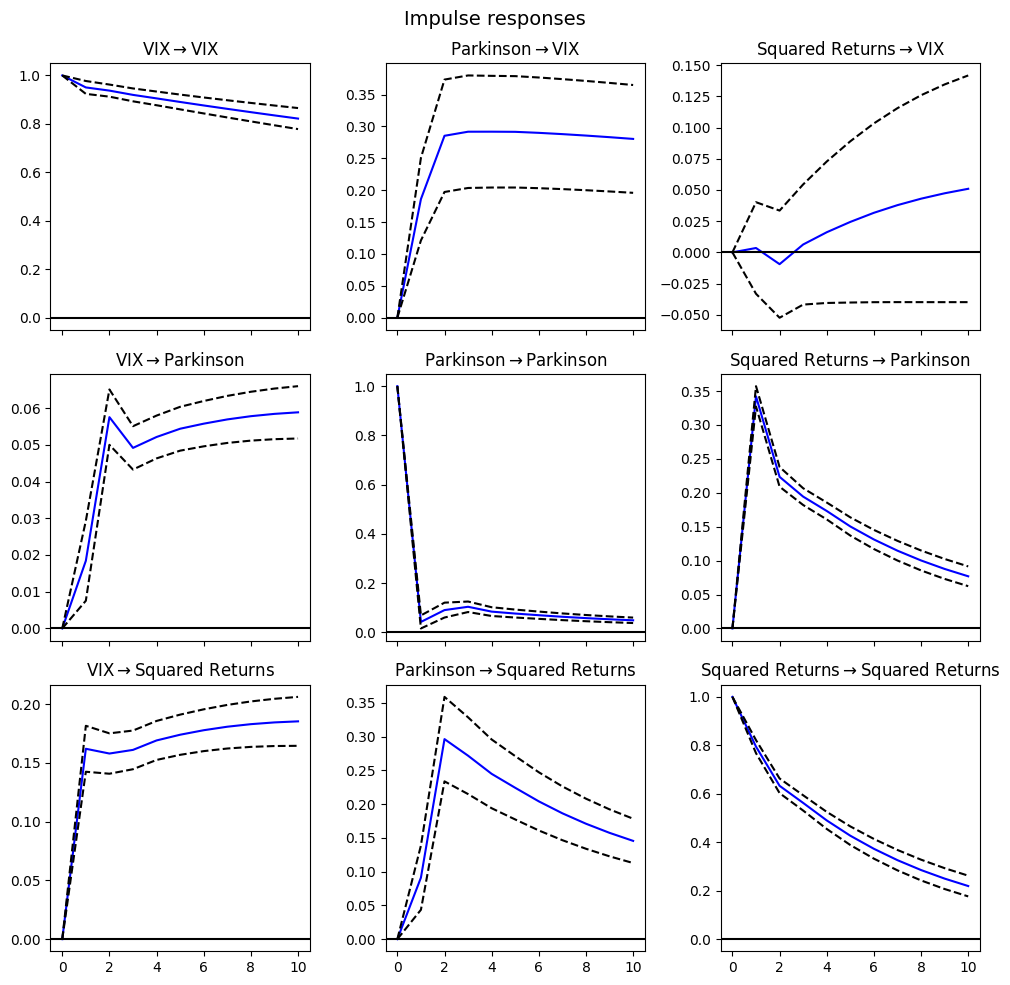

In [173]:
from statsmodels.tsa.vector_ar.irf import IRAnalysis

def plot_impulse_response(results: IRAnalysis, maxlags: int = 10) -> None:
    
    irf = results.irf(maxlags)
    fig = irf.plot()
    plt.tight_layout()
    plt.show()
plot_impulse_response(results_var)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour la fonction de réponse de Parkinson à VIX, on observe une forte augmentation de la réponse à la période 2, qui reste ensuite stable. Cela pourrait suggérer que des chocs positifs dans VIX (l'indice de volatilité du marché boursier) ont un effet durable sur la volatilité de Parkinson (une mesure de la volatilité des rendements du marché boursier). Cette observation peut avoir des implications importantes pour les investisseurs qui cherchent à gérer le risque de leur portefeuille.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour la fonction de réponse de Squared Returns à VIX, on observe une baisse de la réponse à la période 2 (négative), suivie d'une augmentation tout au long du graphique. Cela pourrait suggérer que les chocs positifs dans VIX ont un effet temporaire sur la volatilité des rendements, qui se rétablit progressivement. Cette observation peut être utile pour les investisseurs qui cherchent à identifier des opportunités de trading à court terme.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Pour la fonction de réponse de VIX à Parkinson, on observe une forte augmentation de la réponse à la période 2, suivie d'une légère baisse à la période 3, puis d'une augmentation continue. Cela pourrait suggérer que les chocs positifs dans Parkinson ont un effet important sur la volatilité de VIX, qui se maintient ensuite à un niveau élevé. Cette observation peut être utile pour les investisseurs qui cherchent à comprendre comment les événements économiques et financiers affectent la volatilité du marché boursier.

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px">Il convient de noter que la fonction de réponse peut être interprétée comme une mesure de la dynamique des interactions entre les différentes variables du modèle VAR. Les résultats de la fonction de réponse peuvent donc aider les analystes à mieux comprendre les relations causales entre les variables et à identifier les facteurs clés qui influencent la dynamique du marché boursier. En outre, les résultats peuvent également être utilisés pour évaluer l'efficacité des politiques économiques et financières, ainsi que pour formuler des prévisions sur l'évolution future du marché boursier.

<div align="center">
  <span style="font-family:Lucida Caligraphy;font-size:40px;color:blue;">Merci pour votre attention!</span>
</div>